# 🧪 Load data from PostgreSQL

In [14]:
import pandas as pd
import psycopg2
from sqlalchemy import create_engine
import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Database credentials
DB_NAME = os.getenv("DB_NAME")
DB_USER = os.getenv("DB_USER")
DB_PASSWORD = os.getenv("DB_PASSWORD")
DB_HOST = os.getenv("DB_HOST")
DB_PORT = os.getenv("DB_PORT")

# Create SQLAlchemy engine
connection_string = f"postgresql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
engine = create_engine(connection_string)

# Read data from the hacker_news table
df = pd.read_sql("SELECT * FROM hacker_news", engine)

# Display the first few rows
df.head(10)


,id,title,link,score,author,comments
0,1,Why the Original Macintosh Had a Screen Resolu...,https://512pixels.net/2025/05/original-macinto...,42,ingve,12 comments
1,2,Square Theory,https://aaronson.org/blog/square-theory,343,aaaronson,67 comments
2,3,"Show HN: My LLM CLI tool can run tools now, fr...",https://simonwillison.net/2025/May/27/llm-tools/,13,simonw,2 comments
3,4,Pyrefly vs. Ty: Comparing Python's two new Rus...,https://blog.edward-li.com/tech/comparing-pyre...,196,edwardjxli,83 comments
4,5,Running GPT-2 in WebGL: Rediscovering the Lost...,https://nathan.rs/posts/gpu-shader-programming/,56,nathan-barry,14 comments
5,6,"In Vietnam, an unlikely outpost for Chicano cu...",https://www.latimes.com/world-nation/story/202...,19,donnachangstein,4 comments
6,7,How a hawk learned to use traffic signals to h...,https://www.frontiersin.org/news/2025/05/23/st...,287,layer8,91 comments
7,8,Launch HN: Relace (YC W23) – Models for fast a...,item?id=44108206,56,eborgnia,27 comments
8,9,BGP handling bug causes widespread internet ro...,https://blog.benjojo.co.uk/post/bgp-attr-40-ju...,223,robin_reala,101 comments
9,10,LumoSQL,https://lumosql.org/src/lumosql/doc/trunk/READ...,194,smartmic,76 comments


# 🧹 Data Cleaning – "comments", "score"

In [7]:
# Display basic info
df.info()

# Clean 'comments' column: extract numeric part
df["comments"] = df["comments"].str.extract(r"(\d+)").astype("Int64")  # Nullable int

# Optional: Make sure 'score' is integer (already should be, but double-check)
df["score"] = df["score"].astype("Int64")

# Optional: Check if 'scraped_at' column exists and convert to datetime
if "scraped_at" in df.columns:
    df["scraped_at"] = pd.to_datetime(df["scraped_at"])

# Final check
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790 entries, 0 to 789
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        790 non-null    int64 
 1   title     790 non-null    object
 2   link      790 non-null    object
 3   score     790 non-null    int64 
 4   author    790 non-null    object
 5   comments  790 non-null    object
dtypes: int64(2), object(4)
memory usage: 37.2+ KB


,id,title,link,score,author,comments
0,1,Why the Original Macintosh Had a Screen Resolu...,https://512pixels.net/2025/05/original-macinto...,42,ingve,12
1,2,Square Theory,https://aaronson.org/blog/square-theory,343,aaaronson,67
2,3,"Show HN: My LLM CLI tool can run tools now, fr...",https://simonwillison.net/2025/May/27/llm-tools/,13,simonw,2
3,4,Pyrefly vs. Ty: Comparing Python's two new Rus...,https://blog.edward-li.com/tech/comparing-pyre...,196,edwardjxli,83
4,5,Running GPT-2 in WebGL: Rediscovering the Lost...,https://nathan.rs/posts/gpu-shader-programming/,56,nathan-barry,14


In [9]:
# Ensure all values are string before applying string methods
df["comments"] = df["comments"].astype(str).str.extract("(\d+)").astype(float).fillna(0).astype(int)

# Check result
df["comments"].head()
df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790 entries, 0 to 789
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        790 non-null    int64 
 1   title     790 non-null    object
 2   link      790 non-null    object
 3   score     790 non-null    Int64 
 4   author    790 non-null    object
 5   comments  790 non-null    int64 
dtypes: Int64(1), int64(2), object(3)
memory usage: 37.9+ KB


In [11]:
# Drop rows where title or link is missing
df.dropna(subset=["title", "link"], inplace=True)

# Remove leading/trailing whitespaces
df["title"] = df["title"].str.strip()
df["link"] = df["link"].str.strip()
df["author"] = df["author"].str.strip()


In [12]:
# Check if there are any negative scores
df[df["score"] < 0]


,id,title,link,score,author,comments


In [13]:
df.columns

Index(['id', 'title', 'link', 'score', 'author', 'comments'], dtype='object')

# 📊 Step 1: Top Posts by Score

In [15]:
# Top 10 posts with the highest score
top_scores = df.sort_values(by="score", ascending=False).head(10)
top_scores[["title", "score", "author"]]


,title,score,author
290,Claude 4,1997,meetpateltech
355,Mozilla to shut down Pocket and Fakespot,1201,phantomathkg
750,Watching AI drive Microsoft employees insane,1079,laiysb
29,CSS Minecraft,1071,mudkipdev
144,Postgres IDE in VS Code,1021,Dowwie
446,Trump administration halts Harvard's ability t...,901,S0y
224,Gemini Diffusion,885,mdp2021
392,"Veo 3 and Imagen 4, and a new tool for filmmak...",828,youssefarizk
460,OpenAI to buy AI startup from Jony Ive,818,minimaxir
172,Find Your People,779,jl


# 📣 Step 2: Most Commented Posts

In [17]:
# Top 10 posts with the highest number of comments
df.sort_values(by="comments", ascending=False)[["title", "comments", "author"]].head(10)



,title,comments,author
731,Too Much Grit Can Damage Your Brain,9 comments,msolujic
687,ESP32 MCP Server,9 comments,horw
439,Unix Workstations – The Computer Collection,9 comments,rbanffy
683,Lockheed Martin and IBM combine quantum comput...,9 comments,donutloop
72,Changelog: Lazy trees (faster Nix builds),9 comments,internet_points
561,$200k and still no recovery from Google's algo...,9 comments,arlattimore
753,Ask HN: How much credit can you take for code ...,9 comments,wewewedxfgdf
15,Outcome-Based Reinforcement Learning to Predic...,9 comments,bturtel
557,Accelerating Docker Builds by Halving EC2 Boot...,9 comments,Telstrom90
79,Sqawk: A fusion of SQL and Awk: Applying SQL t...,9 comments,ossusermivami


In [18]:
# Clean the comments column if it's still in string format
if df["comments"].dtype == "object":
    df["comments"] = df["comments"].str.extract("(\d+)").astype(int)


In [ ]:
# Top 10 posts with the highest number of comments

df[["title", "comments", "author"]].sort_values(by="comments", ascending=False).head(10)


,title,comments,author
136,Denmark to raise retirement age to 70,1205,wslh
290,Claude 4,1161,meetpateltech
460,OpenAI to buy AI startup from Jony Ive,1121,minimaxir
446,Trump administration halts Harvard's ability t...,1025,S0y
69,Ask HN: What are you working on? (May 2025),992,david927
97,"At Amazon, some coders say their jobs have beg...",828,milkshakes
355,Mozilla to shut down Pocket and Fakespot,747,phantomathkg
326,How to live on $432 a month in America,728,cactusplant7374
24,Trying to teach in the age of the AI homework ...,560,notarobot123
750,Watching AI drive Microsoft employees insane,550,laiysb


# Top 10 Most Active Authors

In [22]:
top_authors = df['author'].value_counts().head(10)
print(top_authors)

author
todsacerdoti    19
Tomte           18
zdw             11
pseudolus       10
ingve            7
tosh             7
bookofjoe        7
gnabgib          7
thunderbong      7
PaulHoule        6
Name: count, dtype: int64


C:\Users\bahad\AppData\Local\Temp\ipykernel_11300\2237386954.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_authors.values, y=top_authors.index, palette="viridis")


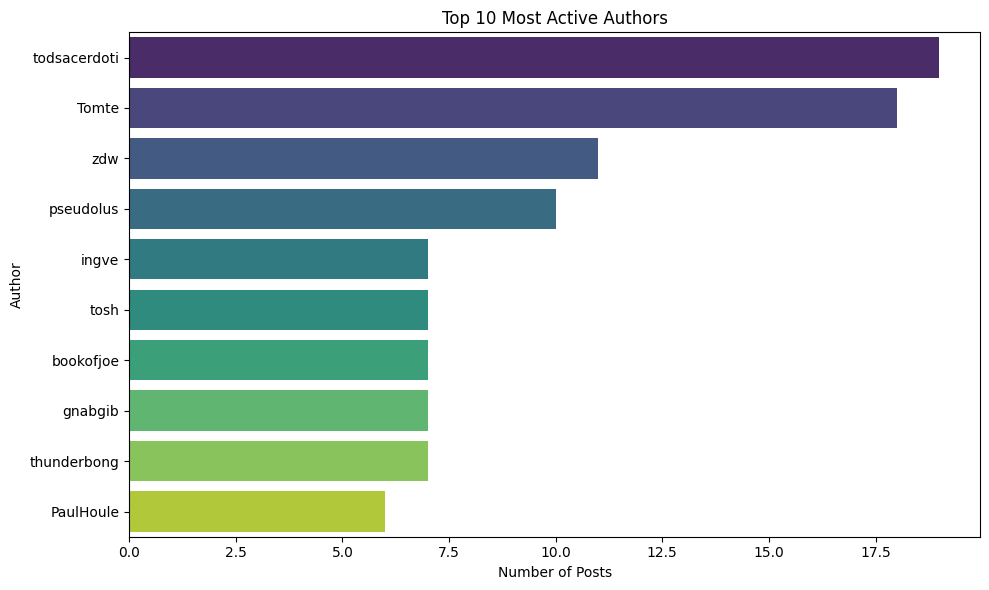

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.barplot(x=top_authors.values, y=top_authors.index, palette="viridis")
plt.title("Top 10 Most Active Authors")
plt.xlabel("Number of Posts")
plt.ylabel("Author")
plt.tight_layout()
plt.show();

# Summary Statistics of Scores and Comments

In [27]:
print("Average Score:", df["score"].mean())
print("Average Comments:", df["comments"].mean())
print(df[["score", "comments"]].describe().T)


Average Score: 92.69873417721519
Average Comments: 51.154430379746834
          count       mean         std  min   25%   50%     75%     max
score     790.0  92.698734  162.656037  0.0  11.0  31.0  109.00  1997.0
comments  790.0  51.154430  122.317385  0.0   1.0   9.0   52.75  1205.0


# Correlation Between Score and Comments

In [28]:
correlation = df["score"].corr(df["comments"])
print(f"Correlation between score and comments: {correlation:.2f}")

Correlation between score and comments: 0.78


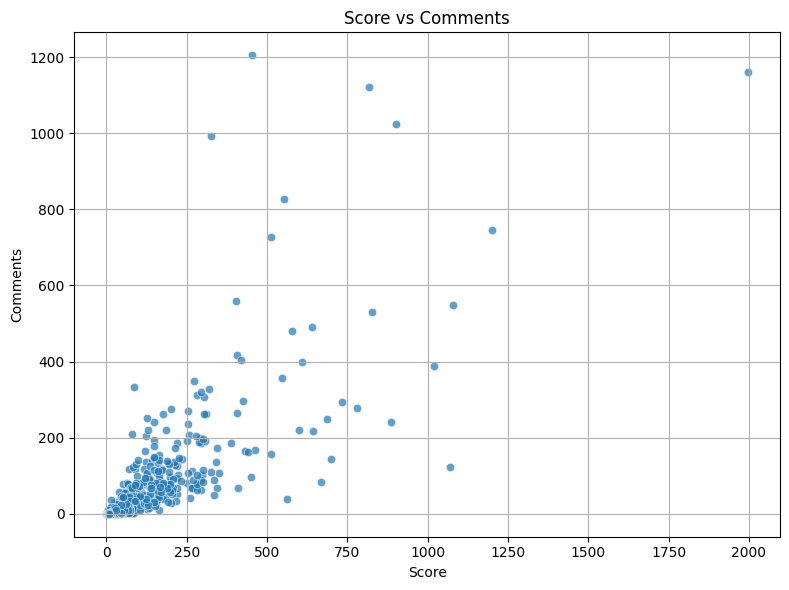

In [29]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x="score", y="comments", alpha=0.7)
plt.title("Score vs Comments")
plt.xlabel("Score")
plt.ylabel("Comments")
plt.grid(True)
plt.tight_layout()
plt.show();

# Distribution of Score and Comments

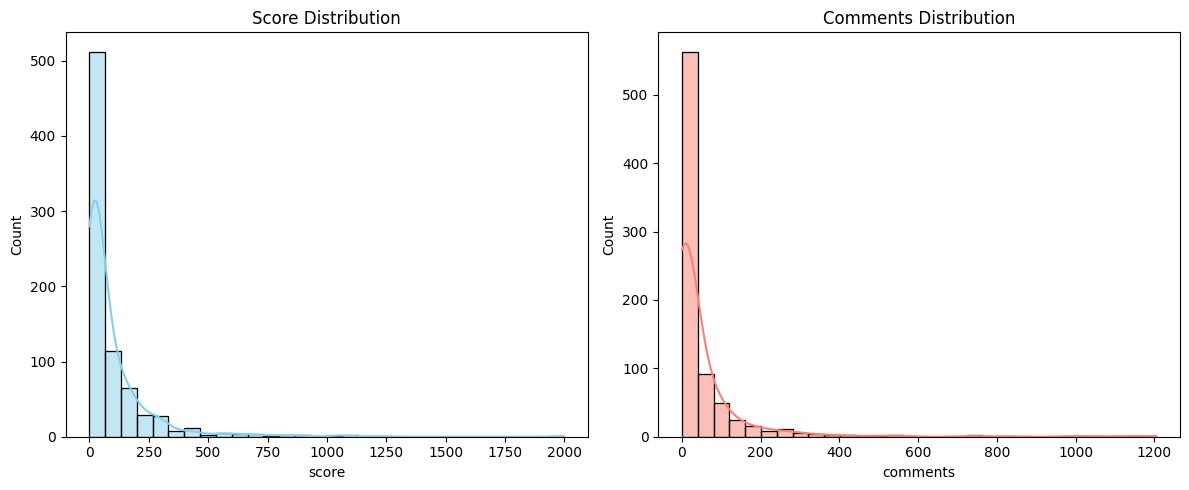

In [30]:
plt.figure(figsize=(12,5))

# Score Distribution
plt.subplot(1, 2, 1)
sns.histplot(df["score"], bins=30, kde=True, color="skyblue")
plt.title("Score Distribution")

# Comments Distribution
plt.subplot(1, 2, 2)
sns.histplot(df["comments"], bins=30, kde=True, color="salmon")
plt.title("Comments Distribution")

plt.tight_layout()
plt.show();


# Top 10 Authors by Total Score (Upvotes)

C:\Users\bahad\AppData\Local\Temp\ipykernel_11300\3327484284.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_authors_by_score.values, y=top_authors_by_score.index, palette="crest")


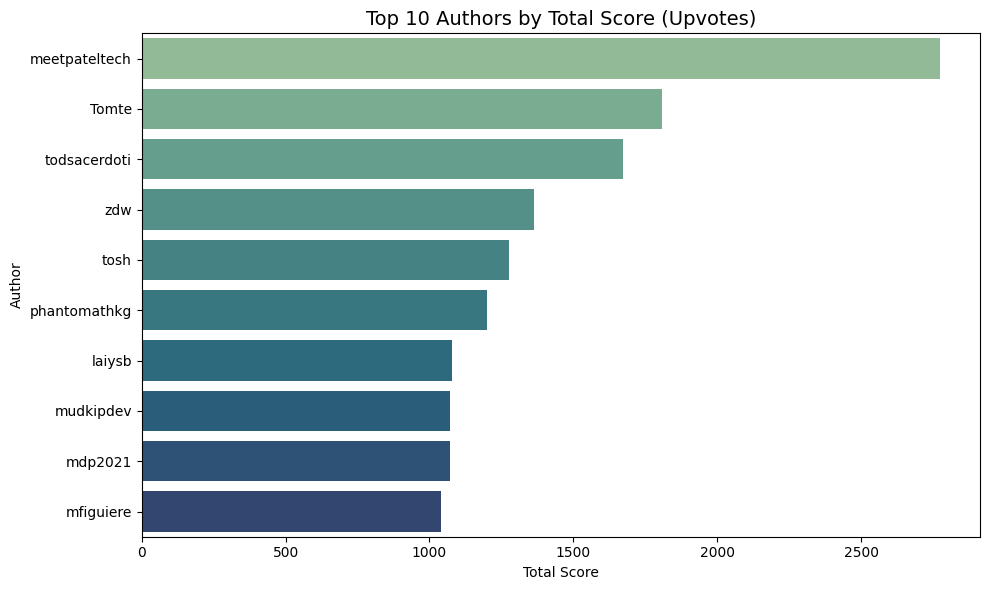

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

top_authors_by_score = df.groupby("author")["score"].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_authors_by_score.values, y=top_authors_by_score.index, palette="crest")
plt.title("Top 10 Authors by Total Score (Upvotes)", fontsize=14)
plt.xlabel("Total Score")
plt.ylabel("Author")
plt.tight_layout()
plt.show();


# Top 10 Authors by Total Comment Count

C:\Users\bahad\AppData\Local\Temp\ipykernel_11300\1535660394.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_authors_by_comments.values, y=top_authors_by_comments.index, palette="flare")


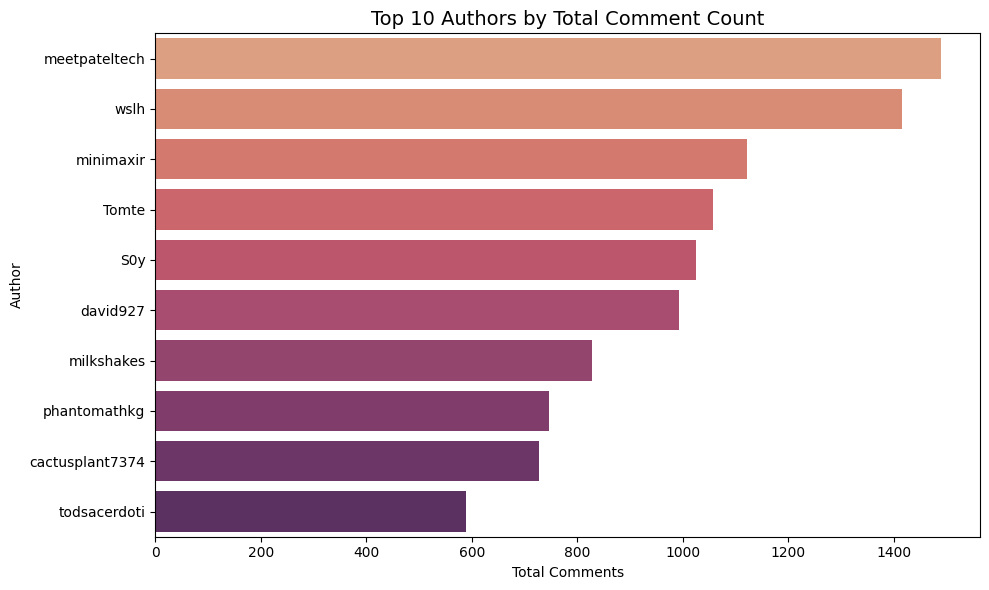

In [32]:
top_authors_by_comments = df.groupby("author")["comments"].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_authors_by_comments.values, y=top_authors_by_comments.index, palette="flare")
plt.title("Top 10 Authors by Total Comment Count", fontsize=14)
plt.xlabel("Total Comments")
plt.ylabel("Author")
plt.tight_layout()
plt.show()


# WordCloud of Most Common Words in Titles

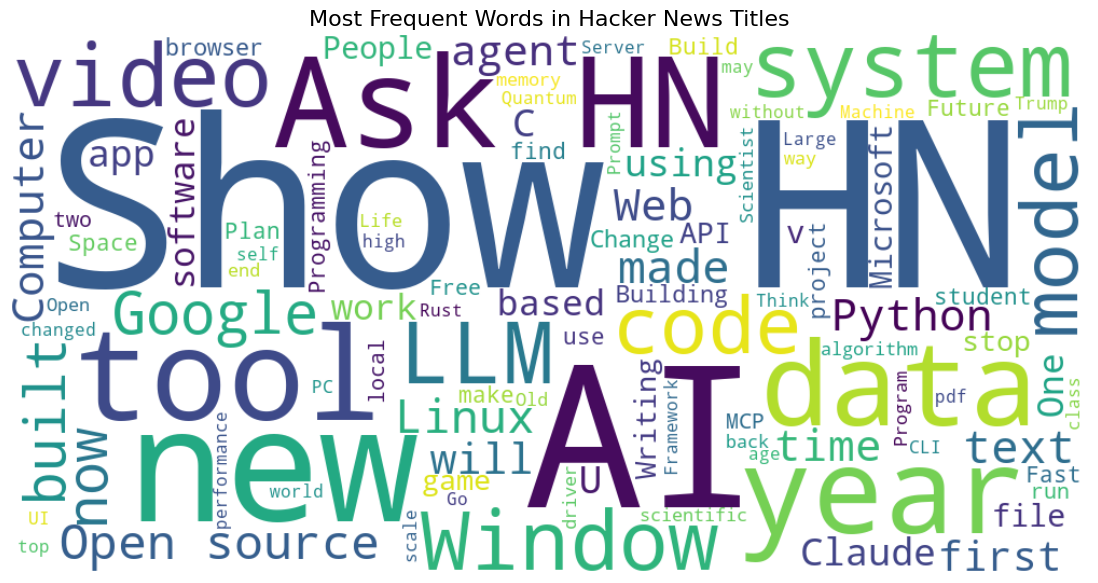

In [33]:
from wordcloud import WordCloud

text = " ".join(df["title"].dropna().astype(str))

wordcloud = WordCloud(width=1000, height=500, background_color='white', colormap='viridis', max_words=100).generate(text)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Most Frequent Words in Hacker News Titles", fontsize=16)
plt.show()


# Relationship Between Title Length and Score

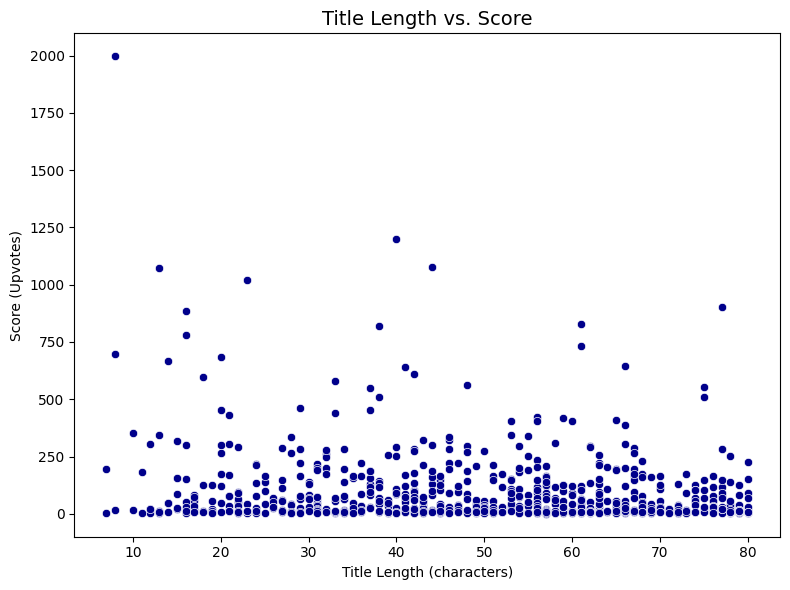

In [34]:
df["title_length"] = df["title"].apply(lambda x: len(x))

plt.figure(figsize=(8, 6))
sns.scatterplot(x="title_length", y="score", data=df, color="darkblue")
plt.title("Title Length vs. Score", fontsize=14)
plt.xlabel("Title Length (characters)")
plt.ylabel("Score (Upvotes)")
plt.tight_layout()
plt.show()


# Relationship Between Title Length and Comment Count

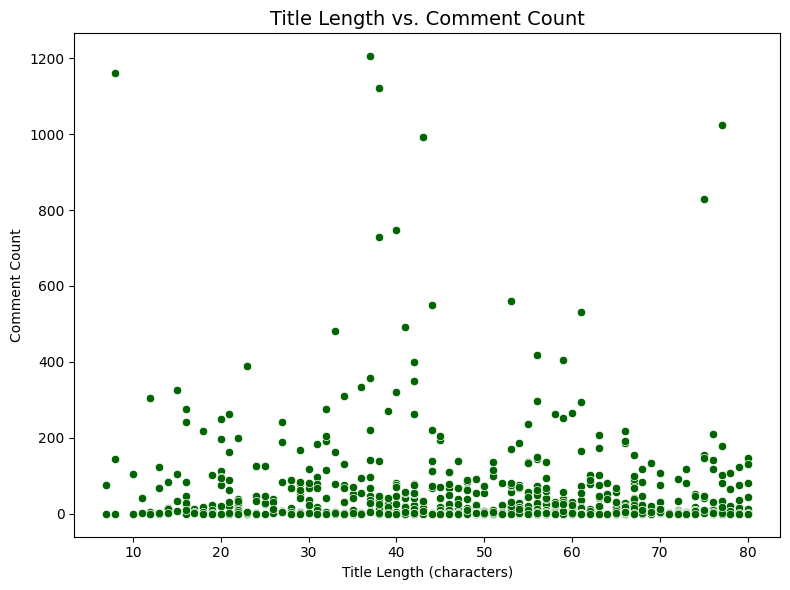

In [35]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x="title_length", y="comments", data=df, color="darkgreen")
plt.title("Title Length vs. Comment Count", fontsize=14)
plt.xlabel("Title Length (characters)")
plt.ylabel("Comment Count")
plt.tight_layout()
plt.show()
